In [1]:
import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import json
import tqdm
import copy
from matplotlib.ticker import MaxNLocator
np.random.seed(0)

In [2]:
def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    return df

In [3]:
df = load_dataframe()

In [4]:
df_flattend = df.copy(True)
flattend_features = pd.DataFrame(np.stack(np.asarray(df_flattend["spect"].apply(lambda x: x.flatten())), axis=0))
df_flattend = pd.concat([df_flattend.filter(items=["caller", "callee"]).reset_index(drop=True), flattend_features.reset_index(drop=True)], axis=1)

In [5]:
df_no_chaos =  df_flattend.loc[~(df_flattend["callee"] == "Chaos")]
y = df_no_chaos["callee"]
X = df_no_chaos.drop(columns=["caller", "callee"])

In [6]:
def get_conf_mats_undersampled(X,y, n_reps = 100):
    conf_mats = []
    rfc = RandomForestClassifier(oob_score=True)
    us = RandomUnderSampler()
    for _ in tqdm.tqdm(range(n_reps)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        X_train_resampled, y_train_resampled = us.fit_resample(X_train,y_train)
        X_test_resampled, y_test_resampled = us.fit_resample(X_test,y_test)
        rfc.fit(X_train_resampled,y_train_resampled)
        y_pred = rfc.predict(X_test_resampled)
        cm = confusion_matrix(y_true=y_test_resampled, y_pred=y_pred, labels=np.unique(y_test_resampled))
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        conf_mats.append(cmn)
    return conf_mats

In [7]:
conf_mats = get_conf_mats_undersampled(X,y)

100%|██████████| 100/100 [1:06:22<00:00, 39.82s/it]


In [8]:
def display_mean_conf_mat(conf_mats, labels, title):
    mean_conf_mat = np.mean(conf_mats, axis=0)
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(mean_conf_mat, annot=True, fmt=".1%", linewidths=1.0, square=1, cmap='rocket_r')
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    return mean_conf_mat

In [9]:
def pred_percent_hist(conf_mats, labels):
    diagonals = []
    for i in range(len(labels)):
        diagonal = []
        for matrix in conf_mats:
            diagonal.append(np.diag(matrix)[i])
        diagonals.append(diagonal)

    plt.figure(figsize=(12,16))
    plt.suptitle("Predictions Percentage Histogram", size=25, y=1.01)
    for i, diagonal in enumerate(diagonals):
        plt.subplot(4, 2, i+1)
        plt.hist(diagonal)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel(f'Percentage', size=15)
        plt.ylabel('Frequency', size=15)
        plt.title(f'Callee {labels[i]}', size=20)

    plt.tight_layout()
    plt.show()

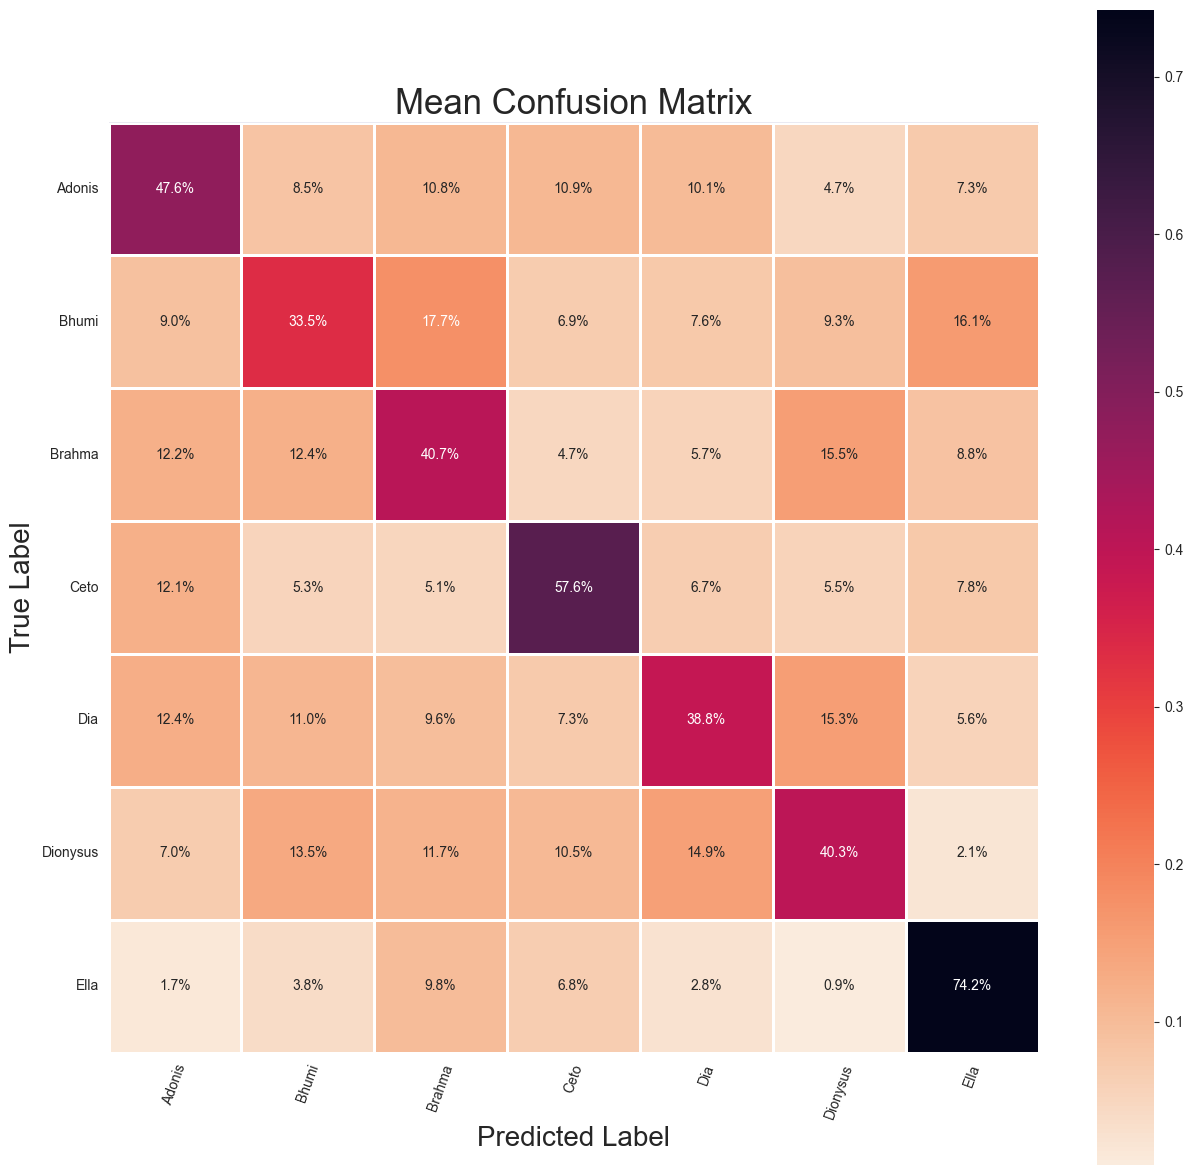

In [10]:
mean_conf_mat = display_mean_conf_mat(conf_mats, np.unique(y), "Mean Confusion Matrix")

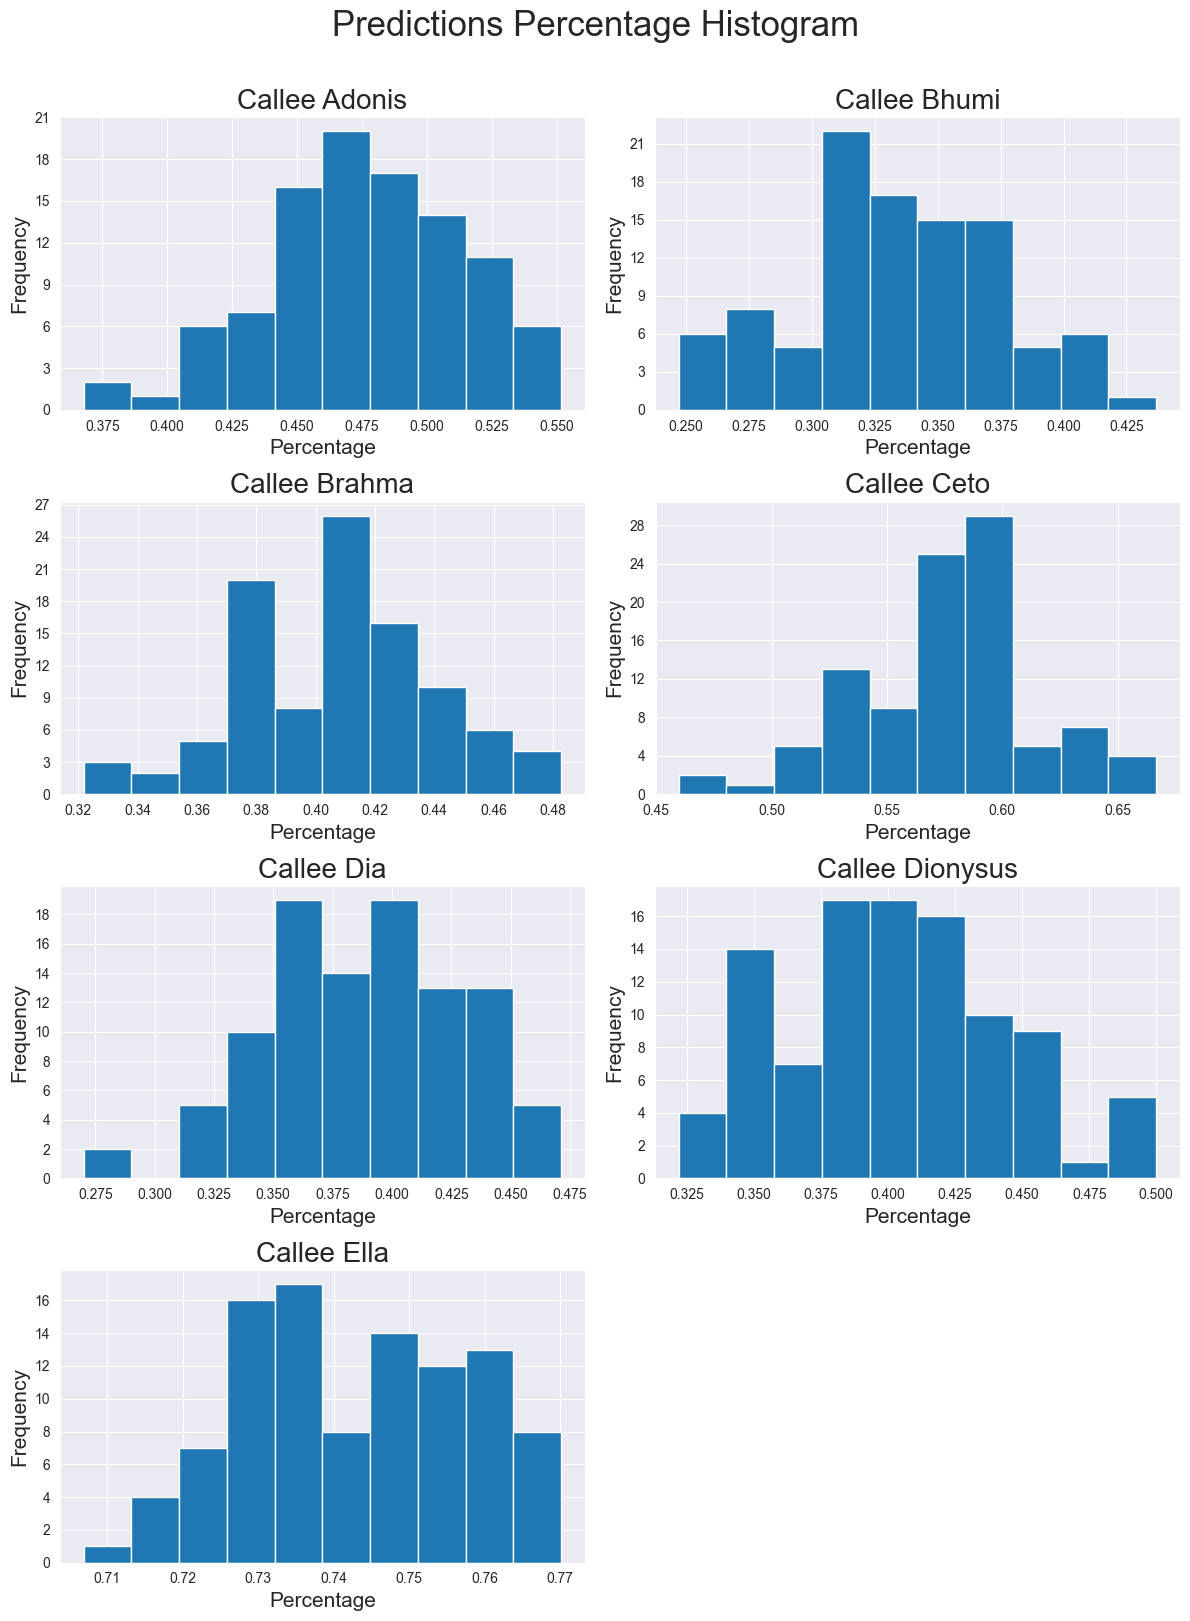

In [12]:
pred_percent_hist(conf_mats, np.unique(y))